# 8. Reparameterization optimization

## Overview

In this tutorial, we will showcase how to optimize the pose of an object correctly counting for the visibility discontinuities. We are going to optimize several latent variables that controls the translation and rotation of the object.

In differentiable rendering, we aim to evaluate the derivative of a pixel intensity integral with respect to a scene parameter $\pi$ as follows:
$$
\partial_\pi I(\pi) = \partial_\pi \int_P f(\bold{x}, \pi) ~ d\bold{x}
$$
where $\bold{x}$ is a light path in the path space $P$. When the function $f(\cdot)$ is continuous with $\pi$, we can move the derivative into the integral and then apply Monte Carlo integration. This justifies the correctness of differentiating the entire rendering pipeline with autodiff, as is done in previous tutorials. But when the discontinuities depend on the scene parameter $\pi$, for example the silhouette of an object could move as we translate it, direct autodiff will yield biased results missing a line integral along the discontinuous boundary. We propose a method based on reparameterization that removes the dependency of discontinuities on scene parameters from the integral.

Reparameterizations for differentiable rendering were proposed in:

      "Reparameterizing discontinuous integrands for differentiable rendering"
      (Proceedings of SIGGRAPH Asia'19) by Guillaume Loubet,
      Nicolas Holzschuch, and Wenzel Jakob.

The specific change of variables used in Mitsuba is described in:

      "Unbiased Warped-Area Sampling for Differentiable Rendering"
      (Procedings of SIGGRAPH'20) by Sai Praveen Bangaru,
      Tzu-Mao Li, and Frédo Durand.

<div class="alert alert-block alert-info">

✔️ **What will you learn?**
    
<ul>
  <li>Perform optimization with discontinuity-aware methods</li>
  <li>Optimize latent variables to control the motion of an object</li>
</ul>
    
</div>


### Step 1 - setup

In [1]:
# Add mitsuba and drjit to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../build/python')

In [2]:
from matplotlib import pyplot as plt

import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_rgb')

In [3]:
from mitsuba.scalar_rgb import ScalarTransform4f as T

def show_image(img, title):
    plt.imshow(mi.util.convert_to_bitmap(img)); plt.axis('off'); plt.title(title);

### Step 2 - scene construction

In [4]:
sensor_to_world = mi.ScalarTransform4f.look_at(
    origin=(0, 0, 2),
    target=(0, 0, 0),
    up=(0, 1, 0)
)
sensor = {
    'type': 'perspective',
    'to_world': sensor_to_world,
    'fov': 60,
    'sampler': {
        'type': 'independent',
        'sample_count': 64
    },
    'film': {
        'type': 'hdrfilm',
        'width': 64,
        'height': 64,
        'rfilter': {
            'type': 'gaussian'
        },
        'sample_border': True
    },
}

In [5]:
integrator = {
    'type': 'prb_reparam', # could be the simpler `direct_reparam` when it is merged
    'reparam_max_depth': 2,
    'max_depth': 2
}

In [6]:
bunny_center = [0.1, -0.3, 1]
scene = mi.load_dict({
    'type': 'scene',
    'sensor': sensor,
    'integrator': integrator,
    # BSDF
    'gray-bsdf': {
        'type': 'diffuse',
        'id': 'gray-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
    },
    'blue-bsdf': {
        'type': 'diffuse',
        'id': 'blue-bsdf',
        'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) },
    },
    # wall
    'plane': {
        'type': 'obj',
        'filename': '../scenes/meshes/rectangle.obj',
        'face_normals': True,
        'bsdf': {'type': 'ref', 'id': 'gray-bsdf'}
    },
    # object
    'bunny': {
        'type': 'ply',
        'filename': '../scenes/meshes/bunny.ply',
        'to_world': T.translate(bunny_center) * T.scale(3.5),
        'bsdf': {'type': 'ref', 'id': 'blue-bsdf'}
    },
    # light
    'light': {
        'type': 'obj',
        'filename': '../scenes/meshes/sphere.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [1e4, 1e4, 1e4]}
        },
        'to_world': T.translate([2.5, 2.5, 7.0]) * T.scale(0.05)
    }
})
integrator = scene.integrator()

2022-03-02 17:24:51 INFO main [Scene] Embree ready. (took 50ms)

### Create a reference scene

In [7]:
params = mi.traverse(scene)
key = 'bunny.vertex_positions'
params.keep([key])
v0 = mi.Float(params[key])

In [8]:
def apply_trafo(params, key, pi):

    pi[0] = dr.clamp(pi[0], -0.5, 0.5)
    pi[1] = dr.clamp(pi[1], -0.5, 0.5)
    pi[2] = dr.clamp(pi[2], -0.5, 0.5)
    dr.enable_grad(pi)  # Normally, we do clamping between `opt.step()` and `opt.update()`. The latter does this `enable_grad()` for us

    trafo = mi.Transform4f.translate(bunny_center) * \
            mi.Transform4f.translate([pi[1], pi[2], 0]) * \
            mi.Transform4f.rotate([0, 1, 0], pi[0] * 100.0) * \
            mi.Transform4f.translate(mi.Vector3f(bunny_center) * -1)
    params[key] = dr.ravel(trafo @ dr.unravel(mi.Point3f, v0))
    params.update()

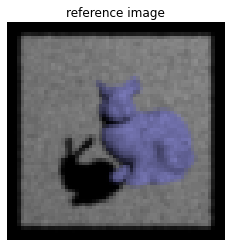

In [9]:
pi_ref = [mi.Float(0.25), mi.Float(0.1), mi.Float(-0.05)]
apply_trafo(params, key, pi_ref)

img_ref = mi.render(scene, seed=0)
show_image(img_ref, "reference image")

### Step 3: optimization

In [10]:
# Restore for optimization
params[key] = mi.Float(v0)
params.update()
pi = [mi.Float(0), mi.Float(0), mi.Float(0)]
img_ini = mi.render(scene, seed=1)

In [11]:
dr.enable_grad(pi)
opt_param = {"deg": pi[0], "trans_x": pi[1], "trans_y": pi[2]}
opt = mi.ad.Adam(lr=0.01, params=opt_param)
opt.load()

In [12]:
def compute_image_loss(img, obj_func):
    dr.enable_grad(img)
    ob_val = obj_func(img)
    dr.backward(ob_val)
    image_loss = dr.grad(img)
    dr.set_grad(img, 0.0)
    return image_loss, dr.detach(ob_val)

def MSE(img):
    return dr.hsum_async(dr.sqr(img - img_ref)) / len(img)

loss_hist = []
for it in range(55):

    apply_trafo(params, key, [opt.variables["deg"], opt.variables["trans_x"], opt.variables["trans_y"]])

    with dr.suspend_grad():
        img_new = mi.render(scene, seed=it+2)
    img_grad, ob_val = compute_image_loss(img_new, MSE)
    integrator.render_backward(scene, params, img_grad)
    # dr.backward_to(pi)  
    # Don't need this: we are calling `backward_from()` in `integrator.sample()` which 
    # propogates gradients through `params` to `pi`

    opt.step()
    opt.update()

    loss_hist.append(ob_val)
    print(f'Iteration {it:02d}: error={ob_val[0]:6f} pi={opt.variables}')

Iteration 00: error=0.003017 pi={'deg': [-0.009997690096497536], 'trans_x': [-0.009997425600886345], 'trans_y': [-0.009999215602874756]}
Iteration 01: error=0.002968 pi={'deg': [-0.019992705434560776], 'trans_x': [-0.01991460472345352], 'trans_y': [-0.019706545397639275]}
Iteration 02: error=0.003000 pi={'deg': [-0.02905532717704773], 'trans_x': [-0.02040114253759384], 'trans_y': [-0.029274344444274902]}
Iteration 03: error=0.002946 pi={'deg': [-0.03676002845168114], 'trans_x': [-0.01697574183344841], 'trans_y': [-0.038799308240413666]}
Iteration 04: error=0.002905 pi={'deg': [-0.04312703758478165], 'trans_x': [-0.011188497766852379], 'trans_y': [-0.04723043367266655]}
Iteration 05: error=0.002792 pi={'deg': [-0.04623238742351532], 'trans_x': [-0.004005114082247019], 'trans_y': [-0.055835723876953125]}
Iteration 06: error=0.002675 pi={'deg': [-0.048042863607406616], 'trans_x': [0.0038922433741390705], 'trans_y': [-0.06376010924577713]}
Iteration 07: error=0.002576 pi={'deg': [-0.049751

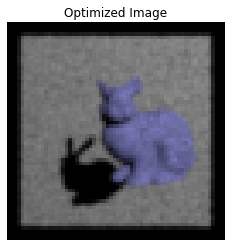

In [13]:
img_fin = mi.render(scene)
show_image(img_fin, "Optimized Image")

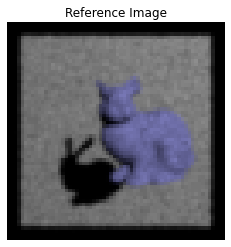

In [14]:
show_image(img_ref, "Reference Image")

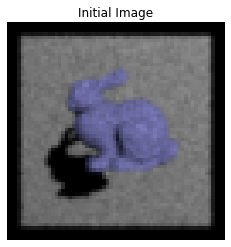

In [15]:
show_image(img_ini, "Initial Image")

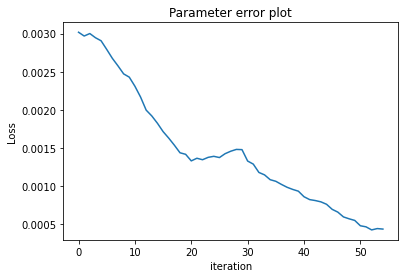

In [16]:
plt.plot(loss_hist)
plt.xlabel('iteration'); plt.ylabel('Loss'); plt.title('Parameter error plot');